## EDA Part 2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, KFold, GridSearchCV
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, NMF, SlopeOne, CoClustering    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
user_ratings = pl.read_csv("../data/no_null_user_ratings/no_null_user_ratings.csv")

In [3]:
pl.DataFrame.estimated_size(user_ratings)

773487713

### Casting our columns

As our dataset is quite large, we had to do abit of casting in hopes of being able to reduce the memory usage when modelling, an error that occured during our early draft phases.

In [4]:
user_ratings = user_ratings.with_column('BGGId', user_ratings['BGGId'].cast(pl.Int32), 'Rating',user_ratings['Rating'].cast(pl.Float32))

C:\Users\siaza\AppData\Local\Temp\ipykernel_19108\3849202470.py:1: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  user_ratings = user_ratings.with_column('BGGId', user_ratings['BGGId'].cast(pl.Int32), 'Rating',user_ratings['Rating'].cast(pl.Float32))


In [5]:
user_ratings_columns = user_ratings.columns

In [6]:
pd_user_ratings = user_ratings.to_pandas()

In [7]:
len(pd_user_ratings['Username'].unique())

411374

We have a total of 411374 non-null user ratings.

In [8]:
pd_user_ratings

,,BGGId,Rating,Username
0,0,213788,8.0,Tonydorrf
1,1,213788,8.0,tachyon14k
2,2,213788,8.0,Ungotter
3,3,213788,8.0,brainlocki3
4,4,213788,8.0,PPMP
...,...,...,...,...
18942147,18942147,165521,3.0,rseater
18942148,18942148,165521,3.0,Bluefox86
18942149,18942149,165521,3.0,serginator
18942150,18942150,193488,1.0,CaptainCattan


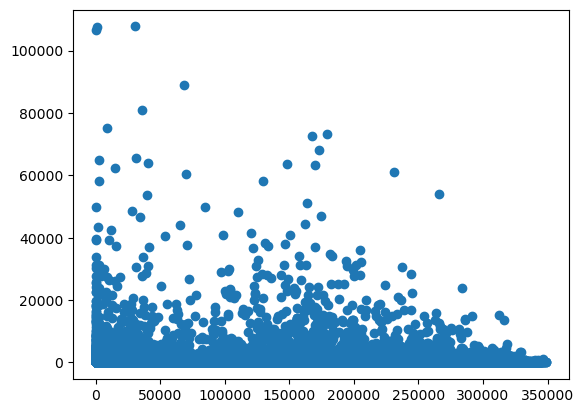

In [9]:
plt.scatter(data = user_ratings.groupby('BGGId').agg([pl.count()]), y = 'count', x = 'BGGId')

We have a large variety of unique user reviews per Board Game ID.

In [10]:
user_ratings.groupby('BGGId').agg([pl.count()])

BGGId,count
i32,u32
169984,105
4096,188
342016,56
322560,71
263168,71
19456,49
5120,72
9216,11035
246784,8983


We examine the Interquartile range to get a better understanding of the distribution of our dataset.

In [18]:
df = user_ratings.groupby('BGGId').agg(pl.count())

In [19]:
q1 = np.percentile(user_ratings.groupby('BGGId').agg(pl.count()).to_numpy(),25)
q3 = np.percentile(user_ratings.groupby('BGGId').agg(pl.count()).to_numpy(),75)

C:\Users\siaza\AppData\Local\Temp\ipykernel_19108\4082892701.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.filter((pl.col('count')>=q1) & (pl.col('count')<=q3)))


<AxesSubplot: ylabel='Density'>

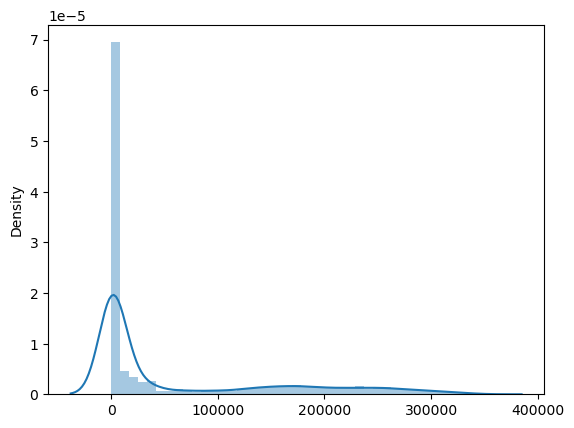

In [20]:
sns.distplot(df.filter((pl.col('count')>=q1) & (pl.col('count')<=q3)))


In [21]:
filtered_df = df.filter((pl.col('count')>=q1) & (pl.col('count')<=q3))

In [22]:
filtered_df

BGGId,count
i32,u32
4096,188
9216,11035
246784,8983
3072,1849
332800,899
136192,590
8192,510
172032,469
254976,395


Even within our Inter Quartile Range, there is a large disparity between our review counts.

In [23]:
# data_for_training,unused_data = train_test_split(pd_user_ratings,test_size=0.9, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)


In [24]:
pd_user_ratings

,,BGGId,Rating,Username
0,0,213788,8.0,Tonydorrf
1,1,213788,8.0,tachyon14k
2,2,213788,8.0,Ungotter
3,3,213788,8.0,brainlocki3
4,4,213788,8.0,PPMP
...,...,...,...,...
18942147,18942147,165521,3.0,rseater
18942148,18942148,165521,3.0,Bluefox86
18942149,18942149,165521,3.0,serginator
18942150,18942150,193488,1.0,CaptainCattan


In [26]:
games_csv = pl.read_csv('../data/no_null_user_ratings/games_after_2010.csv')


C:\Users\siaza\AppData\Local\Temp\ipykernel_19108\1451867377.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_ratings['Rating'])


<AxesSubplot: xlabel='Rating', ylabel='Density'>

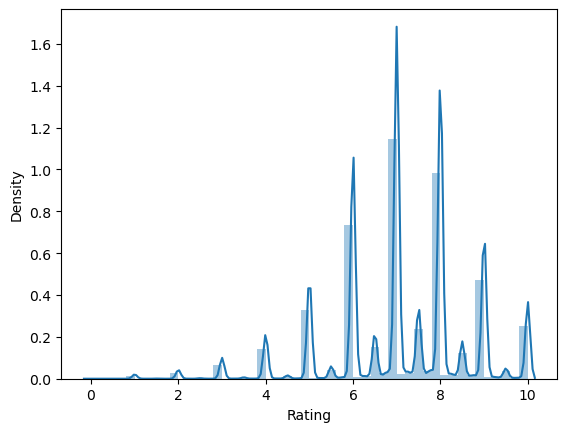

In [28]:
sns.distplot(user_ratings['Rating'])

In [33]:
games_csv2 = games_csv.filter(pl.col('YearPublished') > 2010)
array_fil = games_csv2['BGGId'].to_list()

In [34]:
user_ratings.groupby('Username').count()

Username,count
str,u32
"""Brass_Herald""",541
"""rlphay""",541
"""mormorio""",78
"""chihiro""",416
"""mamachop""",96
"""giamma51""",144
"""Maxpower007""",32
"""Isoroku Vernon...",4
"""brandonjubb""",34


In [35]:
strata = games_csv2.groupby('YearPublished')
# Sample 10% of the data from each stratum
sampled_data = pl.concat([stratum.sample(frac=0.1, seed=42) for _, stratum in strata])
filter_list = sampled_data['BGGId'].to_list()

In [36]:
df_filter_2 = user_ratings.filter(pl.col('BGGId').is_in(filter_list))

In [37]:
df_filter_2

,BGGId,Rating,Username
i64,i32,f32,str
75,193500,5.0,"""Narfbuster"""
76,193500,5.0,"""Methrin"""
77,193500,5.0,"""Evabelle"""
78,193500,5.0,"""ngcx6611"""
79,193500,5.0,"""bmillerbwm"""
80,193500,5.0,"""CadizEstocolmo..."
81,193500,5.0,"""kelvbrown"""
82,193500,5.0,"""jenf"""
83,193500,5.0,"""thatthing1999"""


We still have 10,000,000 rows which is not sustainable for our model. (upwards of 10 hours per run).

In [38]:
df_filter_3 = df_filter_2.to_pandas()

C:\Users\siaza\AppData\Local\Temp\ipykernel_19108\1697110480.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_filter_3['Rating'])


<AxesSubplot: xlabel='Rating', ylabel='Density'>

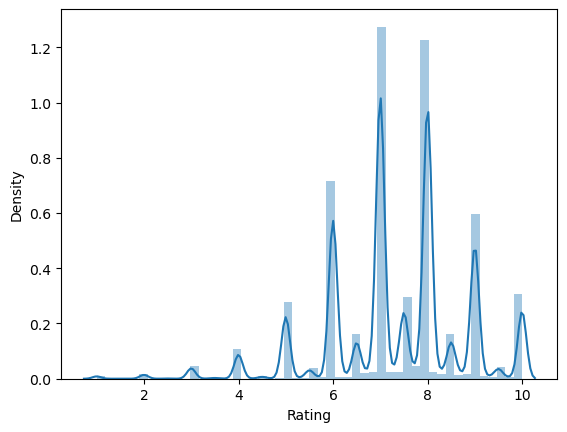

In [39]:
sns.distplot(df_filter_3['Rating'])

We once again look at distribution of ratings across our dataset just to ge a general understanding of our data.

## Final filtering decision

As our problem statement is focused on modern board games we defined any game released in the last 5 years of our dataset as such and will be filtering based on this definition.

In [40]:
games_csv3 = games_csv2.filter(pl.col('YearPublished') > 2016)
array_fil = games_csv3['BGGId'].to_list()

In [41]:
df_filter_2 = user_ratings.filter(pl.col('BGGId').is_in(array_fil))

In [42]:
df_filter_3 = df_filter_2.to_pandas()

In [43]:
df_filter_3['Username'].nunique()

247817

In [44]:
df_filter_2

,BGGId,Rating,Username
i64,i32,f32,str
75,193500,5.0,"""Narfbuster"""
76,193500,5.0,"""Methrin"""
77,193500,5.0,"""Evabelle"""
78,193500,5.0,"""ngcx6611"""
79,193500,5.0,"""bmillerbwm"""
80,193500,5.0,"""CadizEstocolmo..."
81,193500,5.0,"""kelvbrown"""
82,193500,5.0,"""jenf"""
83,193500,5.0,"""thatthing1999"""


In [47]:
df_filter_2.groupby('BGGId').count().describe()

describe,BGGId,count
str,f64,f64
"""count""",5596.0,5596.0
"""null_count""",0.0,0.0
"""mean""",257861.429771,664.936562
"""std""",40867.094461,2291.998924
"""min""",18812.0,29.0
"""max""",349131.0,61200.0
"""median""",256703.0,130.0


C:\Users\siaza\AppData\Local\Temp\ipykernel_19108\45898299.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_filter_2.groupby('BGGId').count()['count'])


(0.0, 500.0)

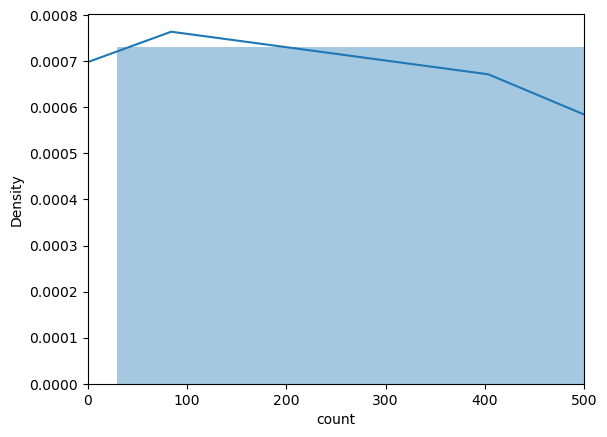

In [59]:
sns.distplot(df_filter_2.groupby('BGGId').count()['count'])
plt.xlim(0,500)

The line that appears on the plot in sns.distplot() is the probability density function estimate. It represents a smoothed curve that approximates the shape of the underlying distribution of the data. By default, the sns.distplot() function uses a kernel density estimate to generate this line. We can see a spike at roughly this number and choose it as our cutoff point.

In [85]:
filter_BGGId = df_filter_2.groupby('BGGId').count().filter(pl.col('count')>=100)['BGGId'].to_list()

In [81]:
np.percentile(df_filter_2.groupby('Username').count()['count'], 97.5)

100.0

We have limited our user pool to be those who have 100 reviews or more for the following reasons:

This is because users who have provided a large number of reviews are likely to have more consistent preferences, which can help to reduce noise in the data and provide a more accurate representation of their tastes.

Limiting dataset to users with 100 or more reviews can also improve the coverage of the recommender system. This is because users who have provided a large number of reviews are likely to have more diverse tastes and interests, which can help to ensure that your recommendations are relevant to a wider range of users.

Reduced bias: Another benefit of limiting dataset to users with 100 or more reviews is that it can help to reduce bias in your recommendations. This is because users who have provided a large number of reviews are likely to be more engaged and invested in the platform, which can help to ensure that they are providing more representative feedback.

In [82]:
list_filter = df_filter_2.groupby('Username').count().filter(pl.col('count')>100)['Username'].to_list()

In [ ]:
len(list_filter)

In [83]:
user_ratings.columns

['', 'BGGId', 'Rating', 'Username']

In [86]:
data_for_model = user_ratings.filter(pl.col('Username').is_in(list_filter) & pl.col('BGGId').is_in(filter_BGGId))

In [87]:
data_for_model.to_pandas().nunique()

            1008727
BGGId          3208
Rating         2902
Username       6150
dtype: int64

In [88]:
data_for_model = data_for_model.to_pandas()

In [89]:
data_for_model = data_for_model.round(2)

In [91]:
data_for_model.nunique()

            1008727
BGGId          3208
Rating          659
Username       6150
dtype: int64

In [92]:
np.percentile(data_for_model['Rating'],50)

7.0

In [90]:
np.percentile(data_for_model['Rating'],60)

7.5

This specific line above is more relevant to our threshold we will be using for our recall@k and precision@k metrics, as although a 7/10 rating would generally be seen as a solid game, we would like our model to perform better than randomly selecting data from our games dataset when making a recommendation.

In [ ]:
data_for_model.to_pickle('..data/data_for_model/data_for_model.pkl')

## EDA Part 2 Conclusion

In EDA Part 2, we have examined the distribution of data, and come to the conclusion that our dataset in order to fit our business need must be limited to games published after 2016, giving our model a 5 year window of data to work with. Our final dataset of 1,008,727 is still diverse with a of 3208 unique BGGIds and 6150 unique users.